In [1]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.preprocessing import RobustScaler

## for explainer
from lime import lime_tabular

In [2]:
# Load CSV and columns
df = pd.read_csv("zalegods/Housing/train.csv")


In [3]:
cols = ["OverallQual","GrLivArea","GarageCars", 
        "GarageArea","TotalBsmtSF","FullBath",
        "YearBuilt","YearRemodAdd",
        "LotFrontage","MSSubClass"]
dtf = df[["Id"]+cols+["SalePrice"]]
dtf.head()

,Id,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,SalePrice
0,1,7,1710,2,548,856,2,2003,2003,65.0,60,208500
1,2,6,1262,2,460,1262,2,1976,1976,80.0,20,181500
2,3,7,1786,2,608,920,2,2001,2002,68.0,60,223500
3,4,7,1717,3,642,756,1,1915,1970,60.0,70,140000
4,5,8,2198,3,836,1145,2,2000,2000,84.0,60,250000


In [4]:
'''
Recognize whether a column is numerical or categorical.
:parameter
    :param dtf: dataframe - input data
    :param col: str - name of the column to analyze
    :param max_cat: num - max number of unique values to recognize a column as categorical
:return
    "cat" if the column is categorical or "num" otherwise
'''
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

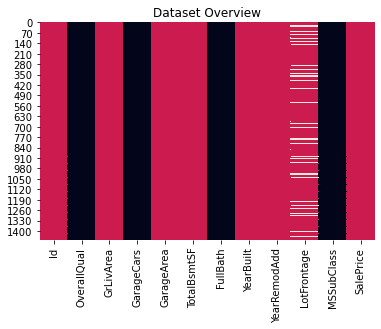

 Categerocial   Numeric   NaN 


In [5]:
dic_cols = {col:utils_recognize_type(dtf, col, max_cat=20) for col in dtf.columns}
heatmap = dtf.isnull()
for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

In [6]:
dtf = dtf.set_index("Id")
dtf = dtf.rename(columns={"SalePrice":"Y"})

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


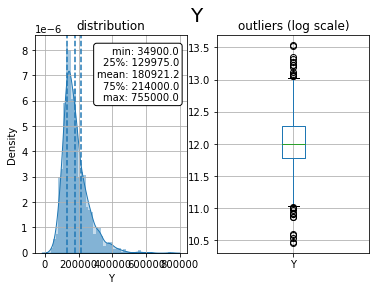

In [7]:
x = "Y"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)
### distribution
ax[0].title.set_text('distribution')
variable = dtf[x].fillna(dtf[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = dtf[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(dtf[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()

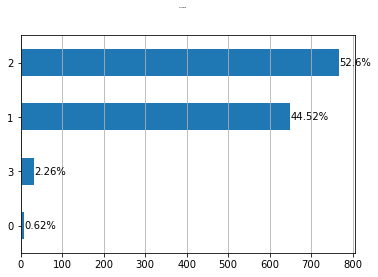

In [8]:
x = "FullBath"
ax = dtf[x].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)

for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
        
ax.grid(axis="x")
plt.suptitle(x, fontsize=2)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdep

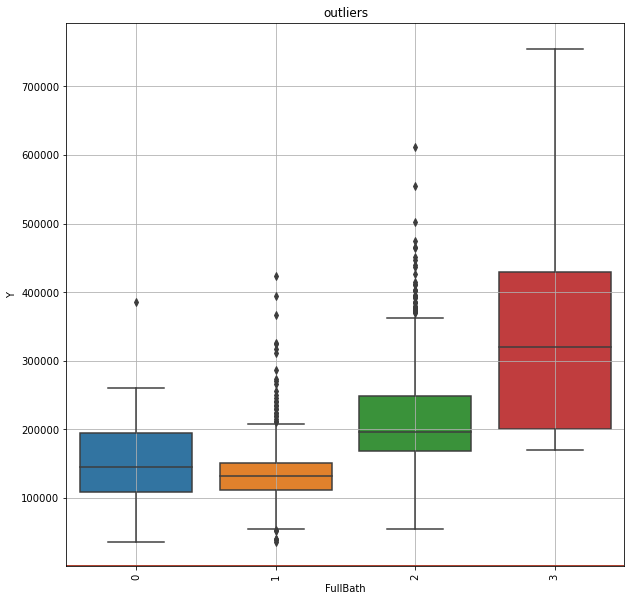

In [43]:
cat, num = "FullBath", "Y"

fig, ax = plt.subplots(figsize=(10,10),  sharex=False, sharey=False)

#fig.suptitle(x+"   vs   "+y,fontsize=20)
            
### distribution
ax.title.set_text('density')

for i in dtf[cat].unique():
    sns.distplot(dtf[dtf[cat]==i][num], hist=False, label=i, ax=ax)
    
ax.grid(True)

### stacked
ax.title.set_text('bins')

breaks = np.quantile(dtf[num], q=np.linspace(0,1,11))

tmp = dtf.groupby([cat, pd.cut(dtf[num], breaks, duplicates='drop')]).size().unstack().T

tmp = tmp[dtf[cat].unique()]

tmp["tot"] = tmp.sum(axis=1)

for col in tmp.drop("tot", axis=1).columns:
     tmp[col] = tmp[col] / tmp["tot"]
        
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax, legend=False, grid=True)

### boxplot   
ax.title.set_text('outliers')

sns.boxplot(x=cat, y=num, data=dtf,  ax=ax)

ax.grid(True)

plt.show()


In [10]:
cat, num = "FullBath", "Y"
model = smf.ols(num+' ~ '+cat, data=dtf).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Correlated (p-value: 0.0)


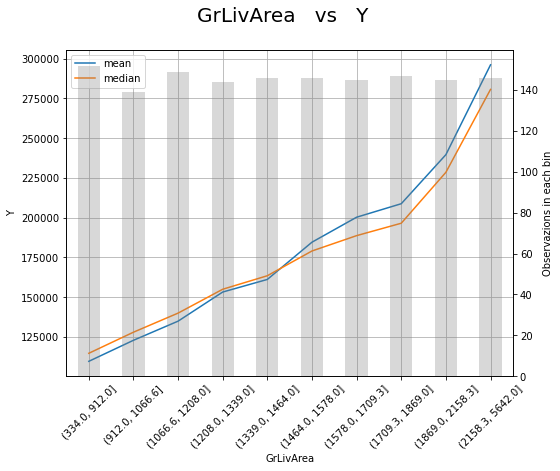

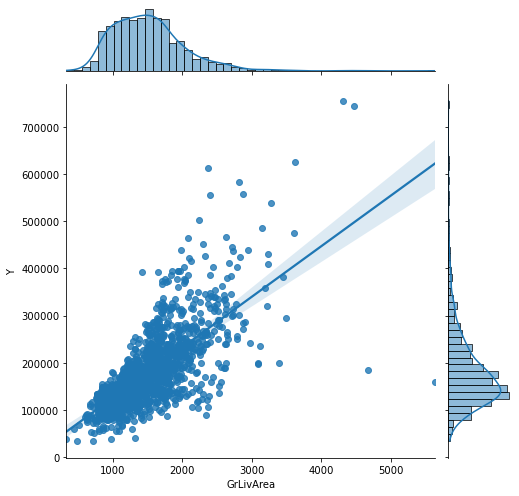

In [12]:
x, y = "GrLivArea", "Y"

figsize=(8, 6)

### bin plot
dtf_noNan = dtf[dtf[x].notnull()]

breaks = np.quantile(dtf_noNan[x], q=np.linspace(0, 1, 11))

groups = dtf_noNan.groupby([pd.cut(dtf_noNan[x], bins=breaks, 
           duplicates='drop')])[y].agg(['mean','median','size'])

fig, ax = plt.subplots(figsize=figsize)

fig.suptitle(x+"   vs   "+y, fontsize=20)

groups[["mean", "median"]].plot(kind="line", ax=ax)

groups["size"].plot(kind="bar", ax=ax, rot=45, secondary_y=True,
                    color="grey", alpha=0.3, grid=True)

ax.set(ylabel=y)

ax.right_ax.set_ylabel("Observazions in each bin")

plt.show()

### scatter plot
sns.jointplot(x=x, y=y, data=dtf, dropna=True, kind='reg', 
              height=int((figsize[0]+figsize[1])/2) )

plt.show()

In [13]:
x, y = "GrLivArea", "Y"
dtf_noNan = dtf[dtf[x].notnull()]
coeff, p = scipy.stats.pearsonr(dtf_noNan[x], dtf_noNan[y])
coeff, p = round(coeff, 3), round(p, 3)
conclusion = "Significant" if p < 0.05 else "Non-Significant"
print("Pearson Correlation:", coeff, conclusion, "(p-value: "+str(p)+")")

Pearson Correlation: 0.709 Significant (p-value: 0.0)


<AxesSubplot:xlabel='MSSubClass', ylabel='Y'>

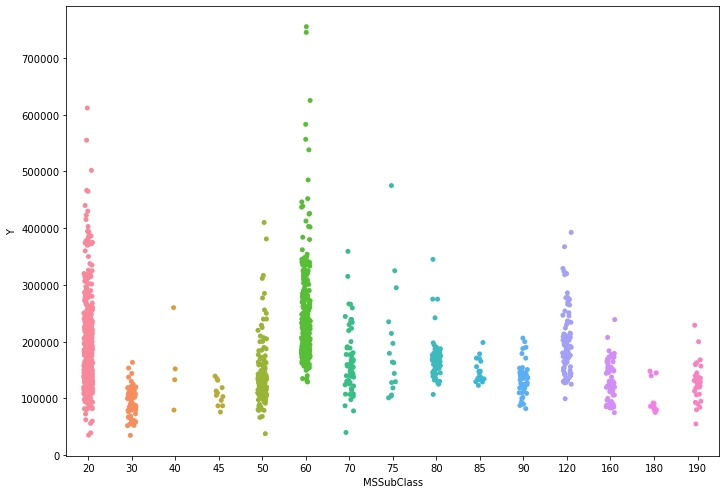

In [32]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.stripplot(ax=ax, x="MSSubClass", y="Y", data=dtf)

In [15]:
x="MSSubClass"

## define clusters
MSSubClass_clusters = {"min":[30,45,180], "max":[60,120], "mean":[]}

## create new columns
dic_flat = {v:k for k,lst in MSSubClass_clusters.items() for v in lst}
for k,v in MSSubClass_clusters.items():
    if len(v)==0:
        residual_class = k 
        
dtf[x+"_cluster"] = dtf[x].apply(lambda x: dic_flat[x] if x in 
                          dic_flat.keys() else residual_class)

## print
dtf[["MSSubClass","MSSubClass_cluster","Y"]].head()


,MSSubClass,MSSubClass_cluster,Y
Id,,,
1,60,max,208500
2,20,mean,181500
3,60,max,223500
4,70,mean,140000
5,60,max,250000


In [16]:
## split data
dtf_train, dtf_test = model_selection.train_test_split(dtf, 
                      test_size=0.3)
## print info
print("X_train shape:", dtf_train.drop("Y",axis=1).shape, "| X_test shape:", dtf_test.drop("Y",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["Y"]),2), "| y_test mean:", round(np.mean(dtf_test["Y"]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop("Y",axis=1).columns.to_list())

X_train shape: (1022, 11) | X_test shape: (438, 11)
y_train mean: 182111.62 | y_test mean: 178143.55
12 features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'LotFrontage', 'MSSubClass', 'MSSubClass_cluster']


In [17]:
dtf_train["LotFrontage"] = dtf_train["LotFrontage"].fillna(dtf_train["LotFrontage"].mean())

<ipython-input-17-ab6c826a6d82>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_train["LotFrontage"] = dtf_train["LotFrontage"].fillna(dtf_train["LotFrontage"].mean())


In [18]:
## create dummy
dummy = pd.get_dummies(dtf_train["MSSubClass_cluster"], 
                       prefix="MSSubClass_cluster",drop_first=True)
dtf_train= pd.concat([dtf_train, dummy], axis=1)
print( dtf_train.filter(like="MSSubClass_cluster",axis=1).head() )
## drop the original categorical column
dtf_train = dtf_train.drop("MSSubClass_cluster", axis=1)

     MSSubClass_cluster  MSSubClass_cluster_mean  MSSubClass_cluster_min
Id                                                                      
976                mean                        1                       0
990                 max                        0                       0
35                  max                        0                       0
533                mean                        1                       0
1329               mean                        1                       0


In [20]:
# Remove two columns name is 'C' and 'D'
#dtf = dtf.drop(['GrLivArea_cluster', 'MSSubClass_cluster'], axis = 1)

In [21]:
## scale X
scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
X = scalerX.fit_transform(dtf_train.drop("Y", axis=1))
dtf_scaled= pd.DataFrame(X, columns=dtf_train.drop("Y", 
                        axis=1).columns, index=dtf_train.index)
## scale Y
scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
dtf_scaled[y] = scalerY.fit_transform(
                    dtf_train[y].values.reshape(-1,1))
dtf_scaled.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,MSSubClass_cluster_mean,MSSubClass_cluster_min,Y
Id,,,,,,,,,,,,,
976,0.5,-0.125622,0.0,0.041494,-0.637044,0.0,0.588235,0.184211,0.000000,2.2,0.0,0.0,0.035936
990,0.5,0.171582,0.0,0.556017,-0.443335,0.0,0.716578,0.342105,-0.265117,0.2,-1.0,0.0,0.403925
35,1.5,0.148602,0.0,0.315353,1.136296,0.0,0.695187,0.315789,-0.518282,1.4,-1.0,0.0,1.329646
533,-0.5,-0.975871,-1.0,-0.365145,-1.981028,-1.0,-0.374332,0.368421,-0.518282,-0.6,0.0,0.0,-0.625293
1329,0.0,2.034470,0.0,0.165975,1.034448,0.0,-1.122995,-1.131579,-0.518282,0.0,0.0,0.0,1.082404


Text(0.5, 1.0, 'pearson correlation')

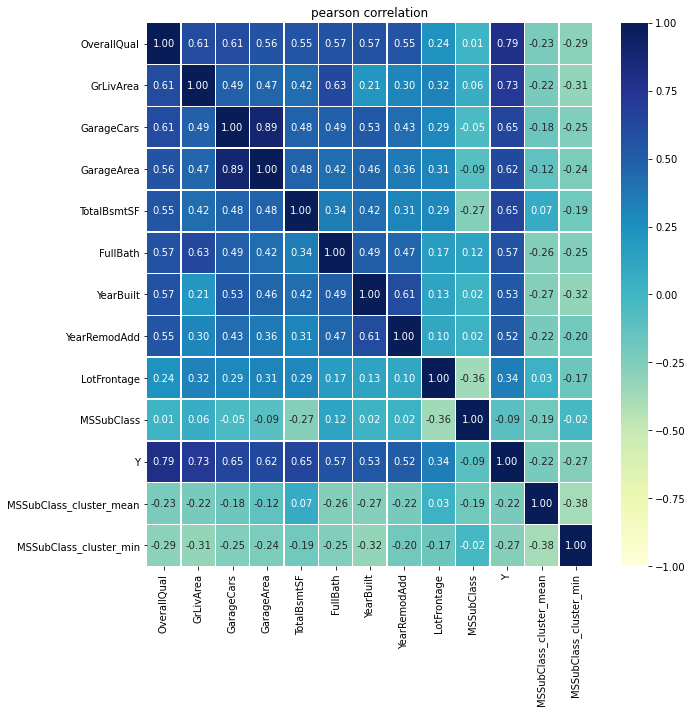

In [25]:
fig, ax = plt.subplots(figsize=(10,10))

corr_matrix = dtf_train.corr(method="pearson")

sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5, ax = ax)

plt.title("pearson correlation")

<AxesSubplot:xlabel='selection', ylabel='features'>

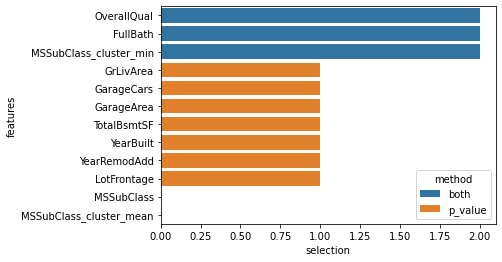

In [45]:
X = dtf_train.drop("Y", axis=1).values
y = dtf_train["Y"].values
feature_names = dtf_train.drop("Y", axis=1).columns
## p-value
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_regression, k=10).fit(X,y)
pvalue_selected_features = feature_names[selector.get_support()]

## regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.Ridge(alpha=1.0, fit_intercept=True), 
                                 max_features=10).fit(X,y)
regularization_selected_features = feature_names[selector.get_support()]
 
## plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["p_value"] = dtf_features["features"].apply(lambda x: "p_value" if x in pvalue_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in pvalue_selected_features else 0)
dtf_features["regularization"] = dtf_features["features"].apply(lambda x: "regularization" if x in regularization_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in regularization_selected_features else 0)
dtf_features["method"] = dtf_features[["p_value","regularization"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
dtf_features["method"] = dtf_features["method"].apply(lambda x: "both" if len(x.split()) == 2 else x)
sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False), dodge=False)

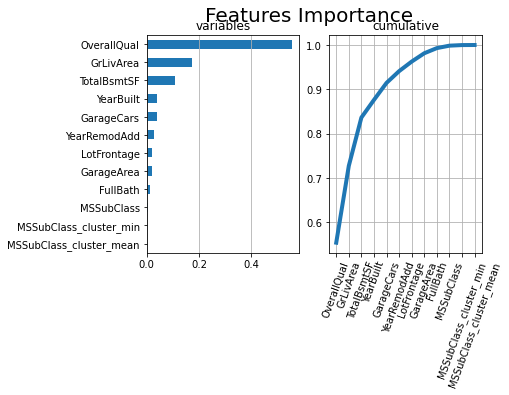

In [49]:
X = dtf_train.drop("Y", axis=1).values
y = dtf_train["Y"].values
feature_names = dtf_train.drop("Y", axis=1).columns.tolist()
## call model
model = ensemble.GradientBoostingRegressor()
## Importance
model.fit(X,y)
importances = model.feature_importances_
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
dtf_importances['cumsum'] =  dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), 
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

In [51]:
X_names = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', "GarageCars"]
X_train = dtf_train[X_names].values
y_train = dtf_train["Y"].values
X_test = dtf_test[X_names].values
y_test = dtf_test["Y"].values

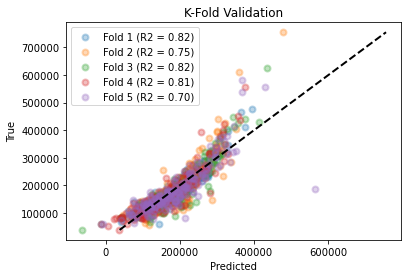

In [52]:
## call model
model = linear_model.LinearRegression()
## K fold validation
scores = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()

In [53]:
## train
model.fit(X_train, y_train)
## test
predicted = model.predict(X_test)

In [54]:
predicted = scalerY.inverse_transform( 
                  predicted.reshape(-1,1) ).reshape(-1)

In [55]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-predicted)/predicted)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))
## residuals
residuals = y_test - predicted
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], predicted[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): -49964076454.79
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 1.0
Mean Absolute Error (Σ|y-pred|/n): 15,672,764,260
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 16,930,383,335
Max Error: -61,797,682,178


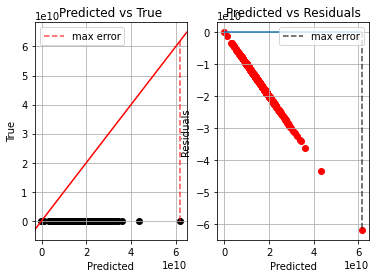

In [56]:
## Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2)
from statsmodels.graphics.api import abline_plot
ax[0].scatter(predicted, y_test, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
## Plot predicted vs residuals
ax[1].scatter(predicted, residuals, color="red")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
ax[1].legend()
plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


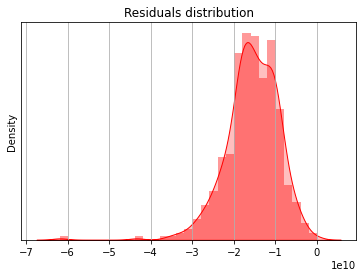

In [57]:
fig, ax = plt.subplots()
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(yticks=[], yticklabels=[], title="Residuals distribution")
plt.show()

In [58]:
print("True:", "{:,.0f}".format(y_test[1]), "--> Pred:", "{:,.0f}".format(predicted[1]))

True: 187,750 --> Pred: 17,809,961,913


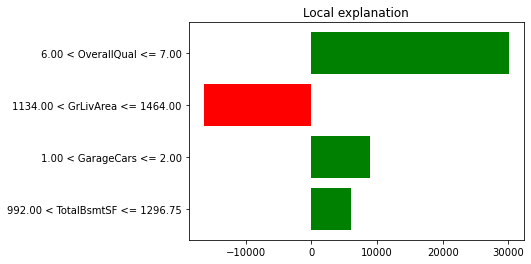

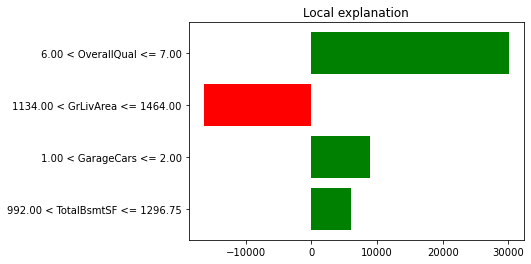

In [59]:
explainer = lime_tabular.LimeTabularExplainer(training_data=X_train, feature_names=X_names, class_names="Y", mode="regression")
explained = explainer.explain_instance(X_test[1], model.predict, num_features=10)
explained.as_pyplot_figure()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 2)

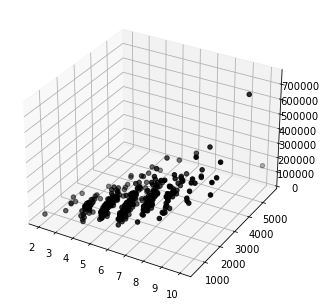

In [60]:
## PCA
pca = decomposition.PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)
## train 2d model
model_2d = linear_model.LinearRegression()
model_2d.fit(X_train, y_train)
## plot regression plane
from mpl_toolkits.mplot3d import Axes3D
ax = Axes3D(plt.figure())
ax.scatter(X_test[:,0], X_test[:,1], y_test, color="black")
X1 = np.array([[X_test.min(), X_test.min()], [X_test.max(), 
               X_test.max()]])
X2 = np.array([[X_test.min(), X_test.max()], [X_test.min(), 
               X_test.max()]])
Y = model_2d.predict(np.array([[X_test.min(), X_test.min(), 
                     X_test.max(), X_test.max()], 
                    [X_test.min(), X_test.max(), X_test.min(), 
                     X_test.max()]]).T).reshape((2,2))
Y = scalerY.inverse_transform(Y)
ax.plot_surface(X1, X2, Y, alpha=0.5)
ax.set(zlabel="Y", title="Regression plane", xticklabels=[], 
       yticklabels=[])
plt.show()
